## 1. 音频 / 语音标注数据处理

In [ ]:
import pathlib
import pickle
import random
from functools import reduce
from collections import Counter

import librosa
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import ticker
from scipy.fftpack import dct
from tqdm import tqdm

plt.rcParams["font.sans-serif"] = ["Times New Roman"]
plt.rcParams["axes.unicode_minus"] = False

# 音频/语音标注文件路径
DS_PATH = "data/"
# 保存文件路径
FILES_PATH = "output/"


### 0. 音频数据处理
读取音频文件 -> 去除静音部分 -> 提取MFCC特征 -> 数据标准化

In [ ]:
# 音频文件路径
data_path = sorted([str(p) for p in pathlib.Path(DS_PATH).glob("*.wav")])
# 语音标注文件路径
label_path = sorted([str(p) for p in pathlib.Path(DS_PATH).glob("*.trn")])
# 查看前5个数据与标注，排序是为了音频与标注文件按名称一一对应
for x, y in zip(data_path[:5], label_path[:5]):
    print(x, y, sep="\t")


In [ ]:
# 数据增强
ex_index = random.sample(range(len(data_path)), len(data_path))
ex_data_path = [data_path[i] for i in ex_index]
ex_label_path = [label_path[i] for i in ex_index]

# 查看前5个数据与标注
for x, y in zip(ex_data_path[:5], ex_label_path[:5]):
    print(x, y, sep="\t")


#### 0.1 读取音频数据并提取MFCC

In [ ]:
def spec_augment(melspec, num_mask=1, freq_masking=0.15, time_masking=0.20):
    """
    对音频进行数据增强, 返回增强后的音频Mel频谱
    :param melspec:       ndarray 需要处理的Mel频谱
    :param num_mask:      int 掩码区域数量
    :param freq_masking   float 频率掩码参数，表示要掩盖的连续频率区域的数量
    :param time_masking:  float 时间掩码参数，表示要掩盖的连续时间区域的数量
    :return               (n_mels, n_frames) 增强后的Mel频谱
    """

    melspec = melspec.copy()
    # 时间/频率屏蔽
    for i in range(num_mask):
        # 随机选择遮挡区域
        freq_dim, time_dim = melspec.shape
        freq_mask_num = int(freq_dim * freq_masking)
        time_mask_num = int(time_dim * time_masking)

        # 随机选择遮挡位置
        freq_mask_pos = np.random.randint(0, freq_dim - freq_mask_num, 1)[0]
        time_mask_pos = np.random.randint(0, time_dim - time_mask_num, 1)[0]

        # 遮挡Mel频谱
        melspec[freq_mask_pos : freq_mask_pos + freq_mask_num, :] = 0
        melspec[:, time_mask_pos : time_mask_pos + time_mask_num] = 0

    return melspec


def load_dataset_mfcc(
    file_path,
    sr=16000,
    n_mfcc=13,
    n_fft=512,
    n_mask=1,
    min_db=23,
    emphasis=0.97,
    hop_length=0.01,
    win_length=0.025,
    lifter=22,
    is_emphasis=False,
    is_spec=False,
):
    """
    加载并提取音频特征, 返回经过预处理的音频mfcc数组
    :param file_path:    list 音频文件路径
    :param sr:           int 音频采样率
    :param n_mfcc:       int mfcc特征维度
    :param n_fft:        int stft计算点数
    :param n_mask:       int 对Mel频谱的掩码数量 (is_spec=True时有效)
    :param min_db:       float 删除静音片段的最小分贝数
    :param emphasis:     float 预加重系数
    :param hop_length:   float 分帧间隔长度
    :param win_length:   float 分窗长度
    :param lifter:       int 对倒谱应用系数提升, 数值为正数
    :param is_emphasis:  bool 是否进行预加重
    :param is_spec:      bool 是否进行额外的数据增强
    :return:             np.ndarray 包含所有音频文件的mfcc特征二维数组 (frames, n_mfcc)
    """
    ds = list()
    for path in tqdm(file_path):
        # 读取文件
        y, sr = librosa.load(path=path, sr=sr)

        # 去除音频中所有的空白静默部分
        y_split = librosa.effects.split(y, top_db=min_db)
        y_split = np.array(
            list(
                reduce(
                    lambda x, y: np.concatenate((x, y)),
                    [y[x[0] : x[1]] for x in y_split],
                )
            )
        )

        # 预加重
        if is_emphasis:
            y_split = librosa.effects.preemphasis(y_split, coef=emphasis)

        # 提取Mel频谱
        y_mel = librosa.feature.melspectrogram(
            y=y_split,
            sr=sr,
            n_fft=n_fft,
            hop_length=int(sr * hop_length),
            win_length=int(sr * win_length),
        )

        # SpecAugment 数据增强
        if is_spec:
            y_mel = spec_augment(y_mel, num_mask=n_mask)

        # 对分贝频谱应用DCT得到MFCC特征
        y_db = librosa.power_to_db(y_mel)
        y_mfcc = dct(y_db, axis=-2, type=2, norm="ortho")[..., :n_mfcc, :]

        # 对MFCC应用提升系数, 可以提高高频部分的分辨率
        if lifter > 0:
            n_lifter = np.sin(
                np.pi * np.arange(1, 1 + n_mfcc, dtype=y_mfcc.dtype) / lifter
            )
            n_lifter = librosa.util.expand_to(n_lifter, ndim=y_db.ndim, axes=-2)
            y_mfcc *= 1 + (lifter / 2) * n_lifter

        # 保存数据 (转置是为了与后续的模型输入层维度匹配)
        ds.append(y_mfcc.transpose())

    return ds


In [ ]:
# mfcc特征维数
MFCC_VALUE = 32
# FFT计算点数
FFT = 512
# 窗长
WINLEN = 0.032


In [12]:
# 读取并处理数据
train_ds = load_dataset_mfcc(
    data_path, n_mfcc=MFCC_VALUE, n_fft=FFT, win_length=WINLEN, is_emphasis=True
)
# ex_train_ds = load_dataset_mfcc(
#     ex_data_path,
#     n_mfcc=MFCC_VALUE,
#     n_fft=FFT,
#     win_length=WINLEN,
#     is_emphasis=True,
#     is_spec=True,
# )

# 拼接数据增强结果
# train_ds.extend(ex_train_ds)
# print(len(train_ds), train_ds[0].shape)


100%|██████████| 13388/13388 [14:12<00:00, 15.70it/s]


#### 0.2 数据标准化
训练集和验证集的最大值、最小值的数值之间存在较大的差距。因此需要通过标准化处理，使特征具有相同的量纲

In [13]:
# 按每列的MFCC维数计算均值
train_ds_std = np.vstack(train_ds)

print(train_ds_std.shape)
print("最大值:", np.max(train_ds_std))
print("最小值", np.min(train_ds_std))
print("均值:", np.mean(train_ds_std))


(9162261, 32)
最大值: 1072.3162
最小值 -2170.3901
均值: -79.20843


In [14]:
# 计算整体均值
mfcc_mean = np.mean(train_ds_std, axis=0)
# 计算整体标准差
mfcc_std = np.std(train_ds_std, axis=0)
del train_ds_std

# 数据标准化: x数据值 - X数据均值 / S标准差
train_ds = [(x - mfcc_mean) / (mfcc_std + 1e-14) for x in train_ds]

# 查看某帧的标准化结果
train_ds[0]

array([[-0.43349   , -0.17045997,  0.630262  , ..., -0.27985716,
         0.26673758,  0.07988792],
       [-0.6624819 , -0.35252732,  0.13227639, ...,  0.22227985,
         0.34292084,  0.34064713],
       [-0.8154033 , -0.38216063,  0.08845794, ...,  0.15161684,
         0.6892472 ,  0.23086607],
       ...,
       [-1.0569092 ,  0.48972937, -0.36593887, ..., -0.791012  ,
        -1.1200867 , -0.64636713],
       [-1.2130592 ,  0.436923  , -0.5065202 , ..., -0.09944178,
        -0.47886017, -0.90331054],
       [-1.3676267 ,  0.28394264, -0.54766285, ..., -0.28404763,
        -0.74950624,  0.23873903]], dtype=float32)

#### EDA: 删除静音部分

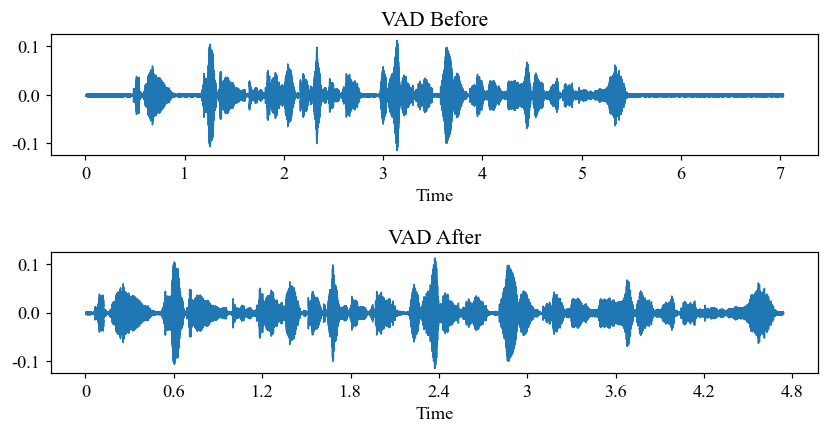

In [15]:
# 随机读取原音频
sound = random.choice(data_path)
y, sr = librosa.load(path=sound, sr=16000)

# 去除分贝小于指定部分的音频区间(空白区间)
y_split = librosa.effects.split(y, top_db=23)
y_split = np.array(
    list(reduce(lambda x, y: np.concatenate((x, y)), [y[x[0] : x[1]] for x in y_split]))
)

# 画图查看结果
plt.figure(figsize=(9, 4), dpi=110)

plt.subplots_adjust(hspace=0.8)

plt.subplot(2, 1, 1)
plt.yticks(fontproperties="Times New Roman", size=12)
plt.xlabel("", fontproperties="Times New Roman", size=12)
plt.xticks(fontproperties="Times New Roman", size=12)
plt.title("VAD Before", font={"size": 14})
librosa.display.waveshow(y)

plt.subplot(2, 1, 2)
plt.yticks(fontproperties="Times New Roman", size=12)
plt.xlabel("", fontproperties="Times New Roman", size=12)
plt.xticks(fontproperties="Times New Roman", size=12)
plt.title("VAD After", font={"size": 14})
librosa.display.waveshow(y_split)

plt.show()


#### EDA: 数据增强

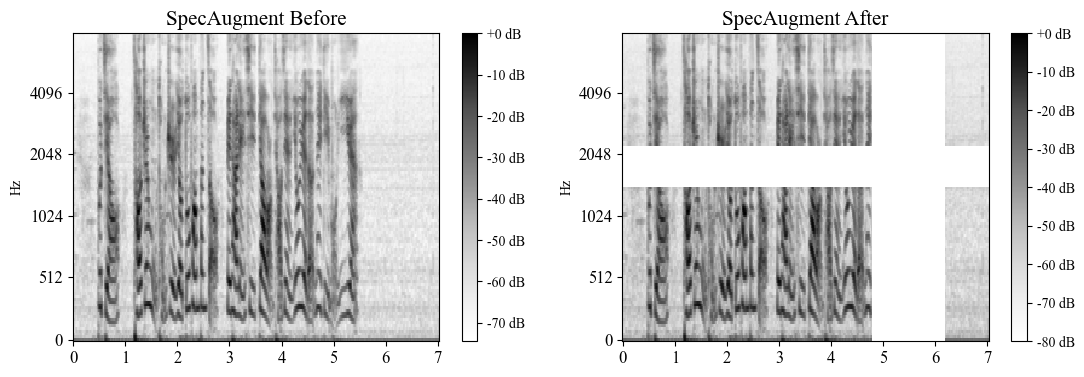

In [16]:
# 提取Mel频谱
mel = librosa.feature.melspectrogram(y=y, sr=sr)
# 数据增强
res = spec_augment(mel, num_mask=1)

# 画图查看结果
plt.figure(figsize=(13, 4), dpi=100)
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
librosa.display.specshow(
    librosa.power_to_db(mel, ref=np.max),
    y_axis="mel",
    fmax=8000,
    x_axis="time",
    cmap="Greys",
)
plt.colorbar(format="%+2.0f dB")
plt.yticks(fontproperties="Times New Roman", size=12)
plt.xlabel("", fontproperties="Times New Roman", size=12)
plt.xticks(fontproperties="Times New Roman", size=12)
plt.title("SpecAugment Before", font={"size": 15})

plt.subplot(1, 2, 2)
librosa.display.specshow(
    librosa.power_to_db(res, ref=np.max),
    y_axis="mel",
    fmax=8000,
    x_axis="time",
    cmap="Greys",
)
plt.colorbar(format="%+2.0f dB")
plt.yticks(fontproperties="Times New Roman", size=12)
plt.xlabel("", fontproperties="Times New Roman", size=12)
plt.xticks(fontproperties="Times New Roman", size=12)
plt.title("SpecAugment After", font={"size": 15})

plt.show()


#### EDA: 查看不同特征维度下的MFCC频谱

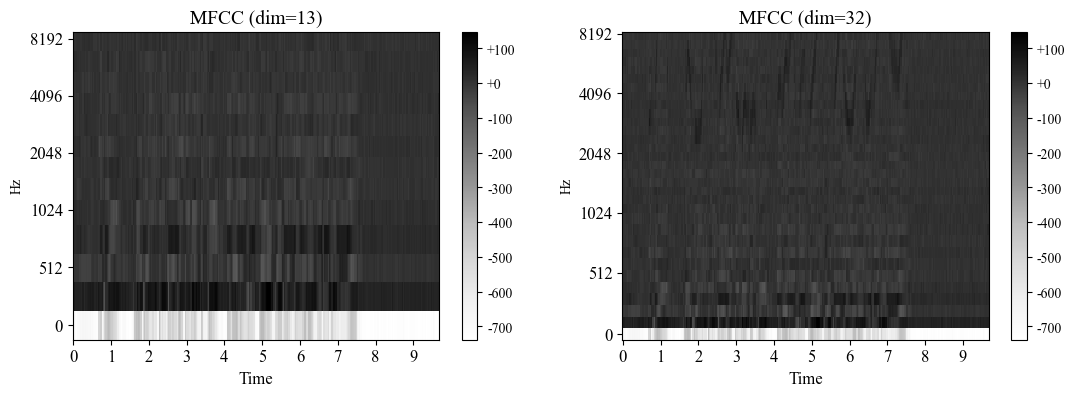

In [17]:
mfcc_a = 13
mfcc_b = 32
sound_mfcc_a = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=mfcc_a, n_fft=FFT)
sound_mfcc_b = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=mfcc_b, n_fft=FFT)

plt.figure(figsize=(13, 4), dpi=100)
plt.subplots_adjust(wspace=0.2)

plt.subplot(1, 2, 1)
plt.yticks(fontproperties="Times New Roman", size=12)
plt.xlabel("", fontproperties="Times New Roman", size=12)
plt.xticks(fontproperties="Times New Roman", size=12)
librosa.display.specshow(
    data=sound_mfcc_a, sr=sr, x_axis="time", y_axis="mel", cmap="Greys"
)
plt.title("MFCC (dim=%d)" % mfcc_a, font={"size": 14})
plt.colorbar(format="%+2.0f")

plt.subplot(1, 2, 2)
plt.yticks(fontproperties="Times New Roman", size=12)
plt.xlabel("", fontproperties="Times New Roman", size=12)
plt.xticks(fontproperties="Times New Roman", size=12)
librosa.display.specshow(
    data=sound_mfcc_b, sr=sr, x_axis="time", y_axis="mel", cmap="Greys"
)
plt.title("MFCC (dim=%d)" % mfcc_b, font={"size": 14})
plt.colorbar(format="%+2.0f")

plt.show()

#### EDA: 查看原音频帧长的分布情况

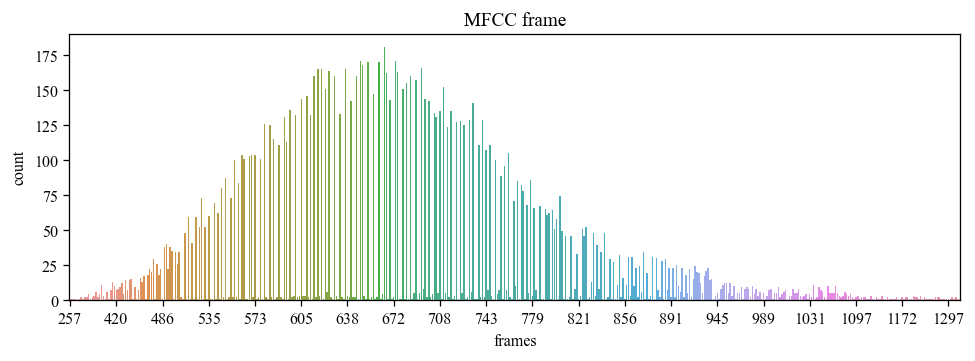

In [18]:
# 计算所有音频的帧数
dim_list = [x.shape[0] for x in train_ds]

# 计数柱状图
plt.figure(figsize=(10, 3), dpi=115)
sns.countplot(x=dim_list, width=0.8)
# 调整x坐标间隔
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(25))
plt.title("MFCC frame")
plt.xlabel("frames")
plt.show()

### 1. 语音标注数据处理
读取标注文件内容 -> 选择字标注作为标签 ->  生成词库 / 标签向量化 -> 映射标签到对应词库文本

#### 1.1 读取标注文件

In [ ]:
labels = list()
ex_labels = list()

# 原数据集
for path in tqdm(label_path):
    with open(path, "r", encoding="utf-8") as file:
        # 读取第一行的字标注
        labels.append(file.readline().strip())

# 数据增强数据集
for path in tqdm(ex_label_path):
    with open(path, "r", encoding="utf-8") as file:
        ex_labels.append(file.readline().strip())

labels[:5]

#### 1.2 使用Counter计算词频，按照词频降序排序后按顺序取标签序号

In [ ]:
text_all = sorted(
    Counter(" ".join(labels).split()).items(), key=lambda x: x[1], reverse=True
)
# 取出排序后的词作为词库
words_list = [x[0] for x in text_all]
del text_all
# 对词库标签向量化
char2id = {word: index for index, word in enumerate(words_list)}
id2char = {index: word for index, word in enumerate(words_list)}

# 查看向量化结果
print(list(char2id.items())[:10])
print(list(id2char.items())[:10])

#### 1.3 映射序号到对应的词库文本

In [ ]:
labels_split = [x.split() for x in labels]
# 映射标签
train_label = list()
for word_list in labels_split:
    train_label.append([char2id[x] for x in word_list])

# 查看前3个标签的映射结果
for label, ids in zip(labels_split[:3], train_label[:3]):
    print("文本:", " ".join(label))
    print("标签:", " ".join([str(x) for x in ids]), end="\n\n")

### 2. 保存音频/标签数据

In [ ]:
# 保存音频MFCC特征, 均值, 标准差
with open(FILES_PATH + "dataset/data_mfcc.pkl", "wb") as file:
    pickle.dump((train_ds, mfcc_mean, mfcc_std), file)

# 保存音频标注
with open(FILES_PATH + "dataset/labels.pkl", "wb") as file:
    labels.extend(ex_labels)
    pickle.dump(labels, file)
    print(len(labels))

# 保存词库
with open(FILES_PATH + "dataset/words_vec.pkl", "wb") as file:
    pickle.dump((char2id, id2char), file)